<IPython.core.display.Math object>

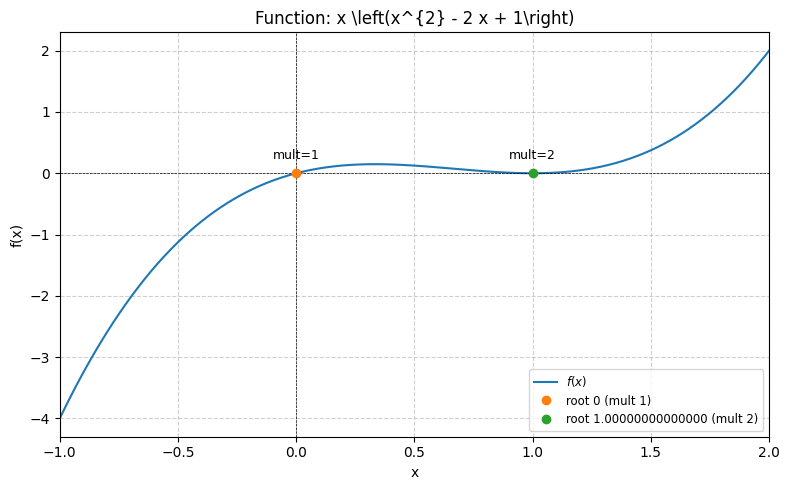

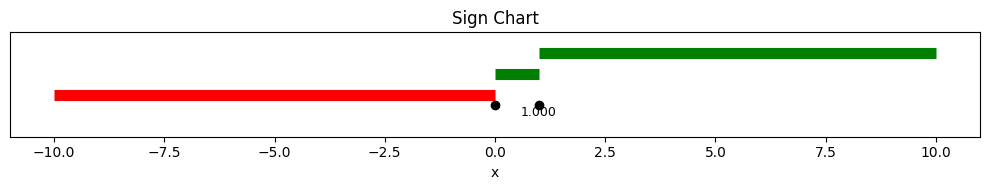

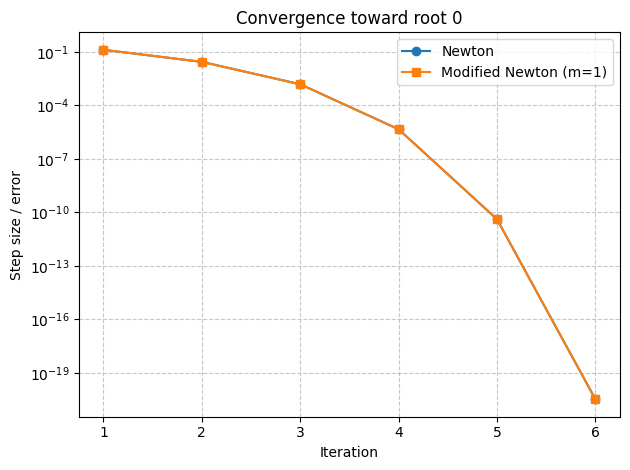

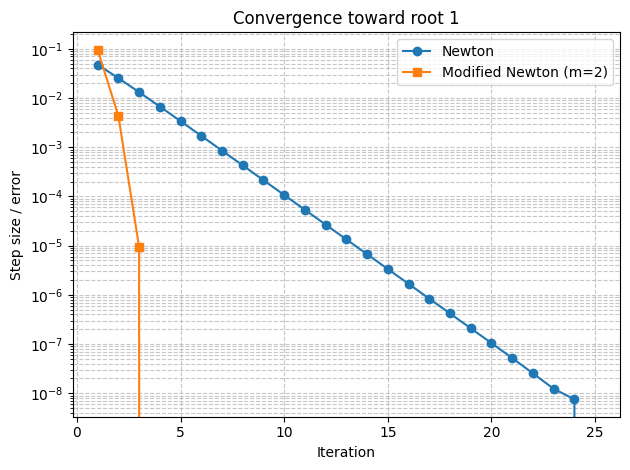

<IPython.core.display.Math object>

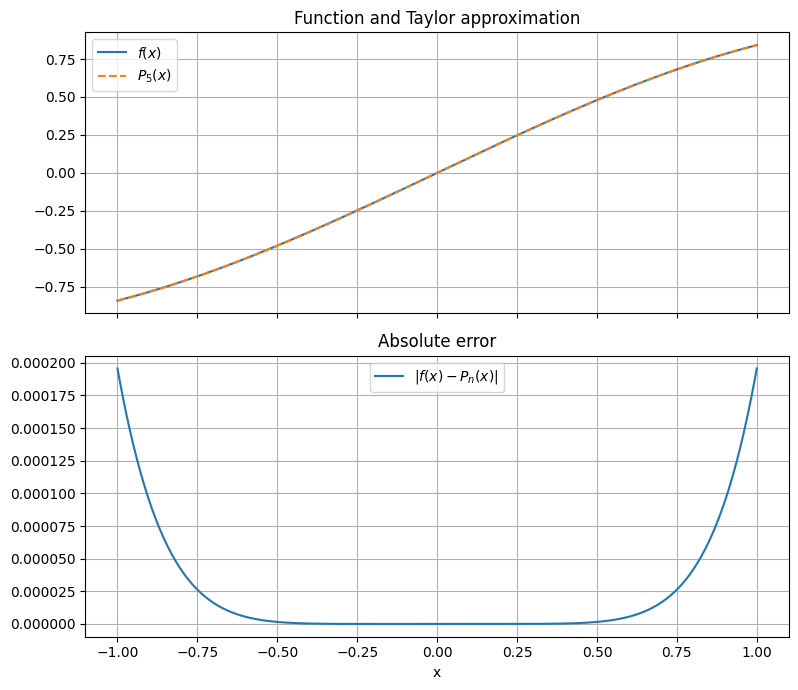

<IPython.core.display.Math object>

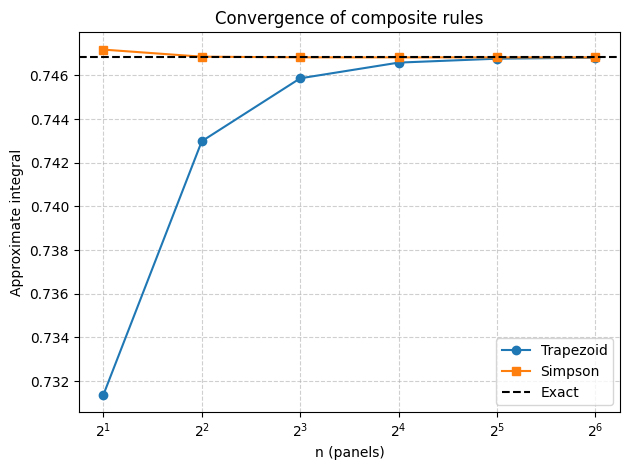

{'exact': sqrt(pi)*erf(1)/2,
 'trapezoid': np.float64(0.7465845967882216),
 'trap_error_bound': np.float64(0.0006510416666666666),
 'simpson': np.float64(0.7468242574357303),
 'simp_error_bound': np.float64(1.0172526041666667e-06),
 'romberg_table': {1: {1: np.float64(0.6839397205857212)},
  2: {1: np.float64(0.7313702518285631), 2: np.float64(0.7471804289095104)},
  3: {1: np.float64(0.7429840978003812),
   2: np.float64(0.7468553797909873),
   3: np.float64(0.7468337098497524)},
  4: {1: np.float64(0.7458656148456952),
   2: np.float64(0.7468261205274666),
   3: np.float64(0.7468241699098985),
   4: np.float64(0.7468240184822817)}}}

In [5]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
from sympy import latex, S

# Inline plotting directive for Colab
%matplotlib inline

# ----------------------------
# 1. Root Finder & Multiplicity Analyzer
# ----------------------------
class RootAnalyzer:
    def __init__(self, expr_str, var_str='x'):
        self.x = sp.symbols(var_str, real=True)
        self.f = sp.simplify(sp.sympify(expr_str, locals={var_str: self.x}))
        self.fprime = sp.diff(self.f, self.x)
        self.fsecond = sp.diff(self.fprime, self.x)
        self.domain = sp.calculus.util.continuous_domain(self.f, self.x, S.Reals)

    def symbolic_roots(self):
        sol = sp.solveset(sp.Eq(self.f, 0), self.x, domain=sp.S.Reals)
        if isinstance(sol, sp.FiniteSet):
            real_roots = []
            for r in sol:
                if (r.is_real or sp.im(r) == 0):
                    real_roots.append(sp.nsimplify(r))
            return sorted(set(real_roots), key=lambda z: sp.N(z))
        return []

    def multiplicity(self, root):
        if not sp.simplify(self.f.subs(self.x, root)) == 0:
            return 0
        m = 1
        while True:
            deriv = sp.diff(self.f, self.x, m)
            val = deriv.subs(self.x, root)
            if val != 0:
                return m
            m += 1
            if m > 30:
                return m  # safety fallback

    def sign_chart(self):
        roots = self.symbolic_roots()
        real_roots = []
        for r in roots:
            try:
                if (r.is_real or sp.im(r) == 0):
                    real_roots.append(float(sp.N(r)))
            except Exception:
                continue
        real_roots = sorted(set(real_roots))
        breakpoints = [-np.inf] + real_roots + [np.inf]
        chart = []
        f_num = sp.lambdify(self.x, self.f, 'numpy')
        for a, b in zip(breakpoints[:-1], breakpoints[1:]):
            if a == -np.inf and b == np.inf:
                test = 0.0
            elif a == -np.inf:
                test = b - 1.0
            elif b == np.inf:
                test = a + 1.0
            else:
                test = (a + b) / 2.0
            try:
                val = f_num(test)
                if np.isnan(val):
                    sign = '?'
                elif val > 0:
                    sign = '+'
                elif val < 0:
                    sign = '-'
                else:
                    sign = '0'
            except Exception:
                sign = '?'
            chart.append(((a, b), sign))
        return chart

    def newton(self, x0, maxiter=30, tol=1e-12):
        seq = []
        x_curr = x0
        f_num = sp.lambdify(self.x, self.f, 'numpy')
        fprime_num = sp.lambdify(self.x, self.fprime, 'numpy')
        for _ in range(maxiter):
            fx = f_num(x_curr)
            fpx = fprime_num(x_curr)
            if fpx == 0 or np.isnan(fpx):
                break
            x_next = x_curr - fx / fpx
            err = abs(x_next - x_curr)
            seq.append((x_next, err))
            if err < tol:
                break
            x_curr = x_next
        return seq

    def modified_newton(self, x0, multiplicity, maxiter=30, tol=1e-12):
        seq = []
        x_curr = x0
        f_num = sp.lambdify(self.x, self.f, 'numpy')
        fprime_num = sp.lambdify(self.x, self.fprime, 'numpy')
        m = multiplicity
        for _ in range(maxiter):
            fx = f_num(x_curr)
            fpx = fprime_num(x_curr)
            if fpx == 0 or np.isnan(fpx):
                break
            x_next = x_curr - m * fx / fpx
            err = abs(x_next - x_curr)
            seq.append((x_next, err))
            if err < tol:
                break
            x_curr = x_next
        return seq

    def convergence_comparison(self, root, offset=0.1):
        r = float(sp.N(root))
        m = self.multiplicity(root)
        x0 = r + offset
        std = self.newton(x0)
        mod = self.modified_newton(x0, m)
        return {'root': root, 'multiplicity': m, 'standard_newton': std, 'modified_newton': mod}

    def vertical_asymptotes(self):
        asymps = []
        try:
            num_f, den_f = sp.fraction(self.f)
            candidates = sp.solve(sp.Eq(den_f, 0), self.x)
            for c in candidates:
                lim_left = sp.limit(self.f, self.x, c, dir='-')
                lim_right = sp.limit(self.f, self.x, c, dir='+')
                if any(l in (sp.oo, -sp.oo) for l in (lim_left, lim_right)):
                    asymps.append(c)
        except Exception:
            pass
        return sorted(set(asymps), key=lambda z: sp.N(z))

    def latex_summary_clean(self):
        roots = self.symbolic_roots()
        # Build clean aligned LaTeX
        lines = []
        lines.append(r"f(x) = %s" % latex(self.f))
        if roots:
            root_parts = []
            for r in roots:
                m = self.multiplicity(r)
                root_parts.append(r"%s\ (\text{mult }%d)" % (latex(r), m))
            lines.append(r"\text{Roots: } %s" % (" , ".join(root_parts)))
        else:
            lines.append(r"\text{Roots: None real}")
        # Sign chart
        chart = self.sign_chart()
        chart_strs = []
        for (a, b), sign in chart:
            if a == -np.inf and b == np.inf:
                interval = r"(-\infty,\infty)"
            elif a == -np.inf:
                interval = f"(-\\infty,{b:.4g})"
            elif b == np.inf:
                interval = f"({a:.4g},\\infty)"
            else:
                interval = f"({a:.4g},{b:.4g})"
            chart_strs.append(f"{interval}: {sign}")
        lines.append(r"\text{Sign chart: } %s" % ("; ".join(chart_strs)))

        tex = r"\begin{aligned}" + " \\\\ ".join(lines) + r"\end{aligned}"
        display(Math(tex))
        return tex

    def plot_sign_chart(self, width=10, height=2):
        chart = self.sign_chart()
        fig, ax = plt.subplots(figsize=(width, height))
        y = 0
        for (a, b), sign in chart:
            left = -10 if a == -np.inf else a
            right = 10 if b == np.inf else b
            if sign == '+':
                ax.hlines(y, left, right, colors='green', linewidth=8)
            elif sign == '-':
                ax.hlines(y, left, right, colors='red', linewidth=8)
            else:
                ax.hlines(y, left, right, colors='gray', linewidth=8)
            y += 1
        for r in self.symbolic_roots():
            try:
                rv = float(sp.N(r))
                ax.plot(rv, -0.5, 'ko')
                ax.text(rv, -1.0, f"{sp.N(r):.4g}", ha='center', fontsize=9)
            except Exception:
                pass
        ax.set_yticks([])
        ax.set_ylim(-2, y)
        ax.set_xlabel("x")
        ax.set_title("Sign Chart")
        plt.tight_layout()
        plt.show()

    def plot_function(self, xlim=None, num=1000):
        # Determine window
        roots = self.symbolic_roots()
        if xlim is not None:
            left, right = xlim
        else:
            floats = []
            for r in roots:
                try:
                    floats.append(float(sp.N(r)))
                except Exception:
                    pass
            if floats:
                mi, ma = min(floats), max(floats)
                span = ma - mi
                padding = max(1.0, 0.5 * span)
                left = mi - padding
                right = ma + padding
            else:
                left, right = -5, 5
        xs = np.linspace(left, right, num)
        f_num = sp.lambdify(self.x, self.f, 'numpy')
        with np.errstate(all='ignore'):
            ys = f_num(xs)
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(xs, ys, label=r"$f(x)$")
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
        ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
        for r in roots:
            try:
                rv = float(sp.N(r))
                m = self.multiplicity(r)
                ax.plot(rv, 0, 'o', label=f"root {sp.N(r)} (mult {m})")
                ax.annotate(f"mult={m}", xy=(rv, 0), xytext=(0, 10),
                            textcoords='offset points', ha='center', fontsize=9)
            except Exception:
                pass
        for va in self.vertical_asymptotes():
            try:
                vaf = float(sp.N(va))
                ax.axvline(vaf, color='orange', linestyle=':', label=f"x={latex(va)} asymptote")
            except Exception:
                pass
        ax.set_xlim(left, right)
        ax.set_ylabel("f(x)")
        ax.set_xlabel("x")
        ax.set_title(f"Function: {latex(self.f)}")
        ax.legend(fontsize='small', loc='best')
        ax.grid(True, which='both', ls='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    def plot_convergence(self, root, offset=0.1):
        comp = self.convergence_comparison(root, offset)
        std = comp['standard_newton']
        mod = comp['modified_newton']
        fig, ax = plt.subplots()
        std_errs = [err for _, err in std]
        mod_errs = [err for _, err in mod]
        ax.plot(range(1, len(std_errs) + 1), std_errs, 'o-', label='Newton')
        ax.plot(range(1, len(mod_errs) + 1), mod_errs, 's-', label=f"Modified Newton (m={comp['multiplicity']})")
        ax.set_yscale('log')
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Step size / error")
        ax.set_title(f"Convergence toward root {latex(root)}")
        ax.legend()
        ax.grid(True, which='both', ls='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def full_report(self, display_plots=True):
        report = {}
        report['roots'] = self.symbolic_roots()
        report['multiplicities'] = {r: self.multiplicity(r) for r in report['roots']}
        report['sign_chart'] = self.sign_chart()
        report['latex_summary'] = self.latex_summary_clean()
        if display_plots:
            self.plot_function()
            self.plot_sign_chart()
            for r in report['roots']:
                self.plot_convergence(r)
        return report

# ----------------------------
# 2. Series Expansion & Remainder Estimator (clean)
# ----------------------------
class SeriesAnalyzer:
    def __init__(self, expr_str, var_str='x'):
        self.x = sp.symbols(var_str, real=True)
        self.f = sp.simplify(sp.sympify(expr_str, locals={var_str: self.x}))

    def taylor_polynomial(self, center=0, order=5):
        series = sp.series(self.f, self.x, center, order + 1).removeO()
        return sp.expand(series)

    def remainder_lagrange_bound(self, x_point, center=0, order=5, samples=1000):
        n = order
        f_np1 = sp.diff(self.f, self.x, n + 1)
        a = float(min(center, x_point))
        b = float(max(center, x_point))
        f_np1_num = sp.lambdify(self.x, f_np1, "numpy")
        xs = np.linspace(a, b, samples)
        with np.errstate(all="ignore"):
            vals = f_np1_num(xs)
        abs_vals = np.abs(vals)
        if np.any(np.isfinite(abs_vals)):
            M = np.nanmax(abs_vals[np.isfinite(abs_vals)])
        else:
            M = np.nan
        try:
            bound = M * abs(x_point - center) ** (n + 1) / float(sp.factorial(n + 1))
        except Exception:
            bound = float("nan")
        return {
            "n_plus_1_derivative": sp.simplify(f_np1),
            "estimated_max_of_derivative": M,
            "lagrange_bound_at_x": bound
        }

    def evaluate_approximation(self, x_val, center=0, order=5):
        Pn = self.taylor_polynomial(center, order)
        f_num = sp.lambdify(self.x, self.f, "numpy")
        Pn_num = sp.lambdify(self.x, Pn, "numpy")
        fx = f_num(x_val)
        px = Pn_num(x_val)
        error = fx - px if (fx is not None and px is not None) else None
        return {
            "f_at_x": fx,
            "P_n_at_x": px,
            "error": error,
            "P_n": Pn
        }

    def plot_approximation(self, x_range, center=0, order=5, num=500):
        left, right = x_range
        xs = np.linspace(left, right, num)
        f_num = sp.lambdify(self.x, self.f, "numpy")
        Pn = self.taylor_polynomial(center, order)
        Pn_num = sp.lambdify(self.x, Pn, "numpy")
        with np.errstate(all="ignore"):
            ys = f_num(xs)
            ys_approx = Pn_num(xs)
        err = np.abs(ys - ys_approx)

        fig, ax = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
        ax[0].plot(xs, ys, label=r"$f(x)$")
        ax[0].plot(xs, ys_approx, "--", label=rf"$P_{{{order}}}(x)$")
        ax[0].set_title("Function and Taylor approximation")
        ax[0].legend()
        ax[0].grid(True)
        ax[1].plot(xs, err, label=r"$|f(x)-P_n(x)|$")
        ax[1].set_title("Absolute error")
        ax[1].set_xlabel("x")
        ax[1].legend()
        ax[1].grid(True)
        plt.tight_layout()
        plt.show()

    def full_summary_clean(self, center=0, order=5, x_eval=None):
        Pn = self.taylor_polynomial(center, order)
        f = self.f
        if x_eval is not None:
            rem_info = self.remainder_lagrange_bound(x_eval, center, order)
            M = rem_info["estimated_max_of_derivative"]
            bound = rem_info["lagrange_bound_at_x"]
            eval_info = self.evaluate_approximation(x_eval, center, order)
            fx = eval_info["f_at_x"]
            px = eval_info["P_n_at_x"]
            error = eval_info["error"]

            tex = r"""\begin{aligned}
f(x) &= %s \\
P_{%d}(x) &= %s \\
\left|R_{%d}(x)\right| &\le \frac{M\,|x - %s|^{%d}}{(%d)!} \approx %s,\quad M \approx %s \\
f(%s) &= %s,\quad P_{%d}(%s) = %s,\quad \text{error} = %s
\end{aligned}""" % (
                latex(f),
                order, latex(Pn),
                order, latex(center), order + 1, order + 1, sp.N(bound, 6), sp.N(M, 6),
                x_eval, sp.N(fx, 8), order, x_eval, sp.N(px, 8), sp.N(error, 8)
            )
            display(Math(tex))
            return {"P_n": Pn, "remainder_info": rem_info, "evaluation": eval_info}
        else:
            tex = r"""\begin{aligned}
f(x) &= %s \\
P_{%d}(x) &= %s \\
R_{%d}(x) &= \frac{f^{(%d)}(\xi)}{(%d)!}(x - %s)^{%d},\quad \xi \text{ between } x \text{ and } %s
\end{aligned}""" % (
                latex(f),
                order, latex(Pn),
                order, order + 1, order + 1, latex(center), order + 1, latex(center)
            )
            display(Math(tex))
            return {"P_n": Pn}

# ----------------------------
# 3. Numerical Integration Study Tool (clean)
# ----------------------------
class IntegrationAnalyzer:
    def __init__(self, expr_str, var_str='x'):
        self.x = sp.symbols(var_str, real=True)
        self.f = sp.simplify(sp.sympify(expr_str, locals={var_str: self.x}))
        self.fprime2 = sp.diff(self.f, self.x, 2)
        self.fprime4 = sp.diff(self.f, self.x, 4)

    def symbolic_integral(self, a, b):
        try:
            a_s = sp.sympify(a)
            b_s = sp.sympify(b)
            I = sp.integrate(self.f, (self.x, a_s, b_s))
            return sp.simplify(I)
        except Exception:
            return None

    def composite_trapezoid(self, a, b, n):
        a_f = float(a)
        b_f = float(b)
        h = (b_f - a_f) / n
        xk = np.linspace(a_f, b_f, n + 1)
        f_num = sp.lambdify(self.x, self.f, "numpy")
        with np.errstate(all="ignore"):
            yk = f_num(xk)
        return h * (0.5 * yk[0] + yk[1:-1].sum() + 0.5 * yk[-1])

    def composite_simpson(self, a, b, n):
        if n % 2 == 1:
            raise ValueError("Simpson requires even n.")
        a_f = float(a)
        b_f = float(b)
        h = (b_f - a_f) / n
        xk = np.linspace(a_f, b_f, n + 1)
        f_num = sp.lambdify(self.x, self.f, "numpy")
        with np.errstate(all="ignore"):
            yk = f_num(xk)
        return h / 3 * (yk[0] + 2 * yk[2:n:2].sum() + 4 * yk[1:n:2].sum() + yk[-1])

    def romberg(self, a, b, max_level=4):
        R = {}
        def T(m):
            return self.composite_trapezoid(a, b, 2 ** (m - 1))
        for m in range(1, max_level + 1):
            R.setdefault(m, {})[1] = T(m)
            for k in range(2, m + 1):
                prev = R[m][k - 1]
                prevm = R[m - 1][k - 1]
                R[m][k] = prev + (prev - prevm) / (4 ** (k - 1) - 1)
        return R

    def estimate_trapezoid_error(self, a, b, n):
        a_f = float(a)
        b_f = float(b)
        f2_num = sp.lambdify(self.x, self.fprime2, "numpy")
        xs = np.linspace(a_f, b_f, 1000)
        with np.errstate(all="ignore"):
            vals = f2_num(xs)
        abs_vals = np.abs(vals)
        M2 = np.nanmax(abs_vals[np.isfinite(abs_vals)]) if np.any(np.isfinite(abs_vals)) else np.nan
        return ((b_f - a_f) ** 3) / (12 * n ** 2) * M2

    def estimate_simpson_error(self, a, b, n):
        if n % 2 == 1:
            raise ValueError("Simpson requires even n for error estimate.")
        a_f = float(a)
        b_f = float(b)
        f4_num = sp.lambdify(self.x, self.fprime4, "numpy")
        xs = np.linspace(a_f, b_f, 1000)
        with np.errstate(all="ignore"):
            vals = f4_num(xs)
        abs_vals = np.abs(vals)
        M4 = np.nanmax(abs_vals[np.isfinite(abs_vals)]) if np.any(np.isfinite(abs_vals)) else np.nan
        return ((b_f - a_f) ** 5) / (180 * n ** 4) * M4

    def full_summary_clean(self, a, b, n_trap=10, n_simp=10, romberg_level=4):
        exact = self.symbolic_integral(a, b)
        T_n = self.composite_trapezoid(a, b, n_trap)
        trap_err_bound = self.estimate_trapezoid_error(a, b, n_trap)
        if n_simp % 2 == 1:
            n_simp += 1
        S_n = self.composite_simpson(a, b, n_simp)
        simp_err_bound = self.estimate_simpson_error(a, b, n_simp)
        R = self.romberg(a, b, max_level=romberg_level)
        romberg_best = R[romberg_level][romberg_level]

        tex = r"""\begin{aligned}
\text{Function: } & f(x) = %s \\
\text{Interval: } & \int_{%s}^{%s} f(x)\,dx = %s \\
\text{Composite trapezoid (}n=%d\text{): } & T_{%d} = %s,\quad \text{error bound } \le %s \\
\text{Composite Simpson (}n=%d\text{): } & S_{%d} = %s,\quad \text{error bound } \le %s \\
\text{Romberg (level=%d): } & R_{%d,%d} = %s
\end{aligned}""" % (
            latex(self.f),
            latex(a), latex(b),
            latex(exact) if exact is not None else r"\text{(unknown)}",
            n_trap, n_trap, sp.N(T_n, 8), sp.N(trap_err_bound, 8),
            n_simp, n_simp, sp.N(S_n, 8), sp.N(simp_err_bound, 8),
            romberg_level, romberg_level, romberg_level, sp.N(romberg_best, 8)
        )
        display(Math(tex))

        # convergence visualization
        ns = [2 ** k for k in range(1, 7)]
        trap_vals = [self.composite_trapezoid(a, b, n) for n in ns]
        simp_vals = []
        for n in ns:
            n_eff = n if n % 2 == 0 else n + 1
            simp_vals.append(self.composite_simpson(a, b, n_eff))
        fig, ax = plt.subplots()
        ax.plot(ns, trap_vals, 'o-', label='Trapezoid')
        ax.plot(ns, simp_vals, 's-', label='Simpson')
        if exact is not None:
            exact_f = float(sp.N(exact))
            ax.axhline(exact_f, color='black', linestyle='--', label='Exact')
        ax.set_xscale('log', base=2)
        ax.set_xlabel('n (panels)')
        ax.set_ylabel('Approximate integral')
        ax.set_title('Convergence of composite rules')
        ax.legend()
        ax.grid(True, which='both', ls='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        return {
            "exact": exact,
            "trapezoid": T_n,
            "trap_error_bound": trap_err_bound,
            "simpson": S_n,
            "simp_error_bound": simp_err_bound,
            "romberg_table": R
        }

# ----------------------------
# Example usage (run these cells after defining classes)
# ----------------------------

# Root analysis example
analyzer = RootAnalyzer("x**3 - 2*x**2 + x", "x")  # roots: 0 (mult 2), 1 (mult 1)
report = analyzer.full_report()
# Series expansion example
series_analyzer = SeriesAnalyzer("sin(x)", var_str='x')
series_analyzer.full_summary_clean(center=0, order=5, x_eval=0.3)
series_analyzer.plot_approximation(x_range=(-1, 1), center=0, order=5)
# Integration example
integration_analyzer = IntegrationAnalyzer("exp(-x**2)", var_str='x')
integration_analyzer.full_summary_clean(0, 1, n_trap=16, n_simp=16, romberg_level=4)
